In [1]:
import torch
import pandas
import numpy as np
from pipeline.diffprep_fix_pipeline import DiffPrepFixPipeline
from pipeline.diffprep_flex_pipeline import DiffPrepFlexPipeline
from prep_space import space
from experiment.experiment_utils import set_random_seed, load_data, build_data, grid_search, makedir, save_result, load_data_multitask

/Users/siddharth/miniconda3/envs/diffprep/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_prep_pipeline(path, prep_space, params, data_dir, dataset):

    X, y = load_data_multitask(data_dir, dataset)
    X_train, y_train, X_val, y_val, X_test, y_test = build_data(X, y, random_state=params["split_seed"])

    prep_pipeline = DiffPrepFixPipeline(prep_space, temperature=params["temperature"],
                                use_sample=params["sample"],
                                diff_method=params["diff_method"],
                                init_method=params["init_method"])
    prep_pipeline.init_parameters(X_train, X_val, X_test)
    prep_pipeline.load_state_dict(torch.load(path))
    #prep_pipeline.eval()

    return prep_pipeline

In [4]:
# define hyper parameters
params = {
    "num_epochs": 2000,
    "batch_size": 512,
    "device": "cpu",
    #"model_lr": [0.1, 0.01, 0.001],
    "model_lr": 0.01,
    "weight_decay": 0,
    "model": 'log',
    "train_seed": 1,
    "split_seed": 1,
    "method": "diffprep_fix",
    "save_model": True,
    "logging": False,
    "no_crash": False,
    "patience": 3,
    "momentum": 0.9
}

auto_prep_params = {
    "prep_lr": None,
    "temperature": 0.1,
    "grad_clip": None,
    "pipeline_update_sample_size": 512,
    "init_method": "default",
    "diff_method": "num_diff",
    "sample": False
}

params.update(auto_prep_params)

DATADIR = "data"
dataset = "Airbnb"


In [5]:
prep_pipeline_rating = load_prep_pipeline('./result/diffprep_fix/Airbnb/Rating_ground_truth/prep_pipeline.pth', space, params, DATADIR, dataset)

In [6]:
sim = 0.5

In [7]:
import torch.nn.functional as F

In [8]:
rating_pipeline_params = prep_pipeline_rating.state_dict()

In [9]:
def get_pipeline_ops(prep_pipeline_params):
    pipeline_ops = {}
    for pipeline_step, pipeline in prep_pipeline_params.items():
        #print(pipeline_step, pipeline.shape)
        pipeline = F.softmax(pipeline)
        #pipeline_arr = pipeline.numpy()
        #pipeline_ops[pipeline_step] = pipeline_arr.argmax(axis=1)
        pipeline_ops[pipeline_step] = pipeline
    return pipeline_ops

In [10]:
rating_pipeline_ops = get_pipeline_ops(rating_pipeline_params)

In [11]:
import matplotlib.pyplot as plt

In [12]:
sims = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
mean_agr = []
mean_ce = []
all_agrs = []
all_ces = []

synth_rating_pipeline_ops_map = {}

In [13]:
for sim in sims:
    ces = []
    agrs = []
    prep_pipeline_rating_synth = load_prep_pipeline(f'./result/diffprep_fix/Airbnb/Rating_{sim}/prep_pipeline.pth', space, params, DATADIR, dataset)
    synth_rating_pipeline_params = prep_pipeline_rating_synth.state_dict()
    synth_rating_pipeline_ops = get_pipeline_ops(synth_rating_pipeline_params)
    synth_rating_pipeline_ops_map[sim] = synth_rating_pipeline_ops
    for pipeline_step in rating_pipeline_params.keys():
        rating_pipeline_op = rating_pipeline_ops[pipeline_step]

        synth_rating_pipeline_op = synth_rating_pipeline_ops[pipeline_step]

        ce = -(synth_rating_pipeline_op * np.log2(rating_pipeline_op)).sum(axis=1).mean()
        agr = (synth_rating_pipeline_op.argmax(axis=1) == rating_pipeline_op.argmax(axis=1)).numpy().mean()

        #print(pipeline_step)
        #print("CE", ce)
        #print("Agreement %", pipeline_step, agr)
        ces.append(ce)
        agrs.append(agr)

    all_agrs.append(agrs)
    all_ces.append(ces)

    mean_agr.append(np.array(agrs).mean())
    mean_ce.append(np.array(ces).mean())

    #plt.plot(ces)

In [14]:
tf_keys = ['pipeline.0.num_tf_prob_logits', 'pipeline.0.cat_tf_prob_logits', 'pipeline.1.tf_prob_logits', 'pipeline.2.tf_prob_logits', 'pipeline.3.tf_prob_logits']
operation_names = ['Numerical Imputation', 'Categorical Imputation', 'Normalization', 'Outlier Removal', 'Discretization']

ops_agr_mean = {}
ops_agr_stddev = {}
ops_agr_arrs = {}

In [15]:
for op_name, key in zip(operation_names, tf_keys):
    ops_agreement = []
    for sim in sims:
        synth_rating_pipeline_exact_ops = np.argmax(synth_rating_pipeline_ops_map[sim][key], axis=1)
        rating_pipeline_exact_ops = np.argmax(rating_pipeline_ops[key], axis=1)
        ops_agreement.append((synth_rating_pipeline_exact_ops == rating_pipeline_exact_ops).numpy().mean())
    ops_agreement = np.array(ops_agreement)
    ops_agr_arrs[op_name] = ops_agreement
    ops_agr_mean[op_name] = ops_agreement.mean()
    ops_agr_stddev[op_name] = ops_agreement.std()

In [16]:
ops_agr_arrs['Normalization']

array([0.824, 0.856, 0.824, 0.592, 0.88 , 0.648, 0.888, 0.568, 0.88 ])

In [17]:
ops_agr_stddev

{'Numerical Imputation': 0.008493775149387942,
 'Categorical Imputation': 0.00927837023781506,
 'Normalization': 0.12410748030101436,
 'Outlier Removal': 0.06827685109216539,
 'Discretization': 0.03597530016861877}

In [18]:
import seaborn as sns

In [19]:
ops_agr_mean

{'Numerical Imputation': 0.9969969969969968,
 'Categorical Imputation': 0.9924242424242424,
 'Normalization': 0.7733333333333333,
 'Outlier Removal': 0.7742222222222223,
 'Discretization': 0.8560000000000001}

In [20]:
ops_agr_stddev

{'Numerical Imputation': 0.008493775149387942,
 'Categorical Imputation': 0.00927837023781506,
 'Normalization': 0.12410748030101436,
 'Outlier Removal': 0.06827685109216539,
 'Discretization': 0.03597530016861877}

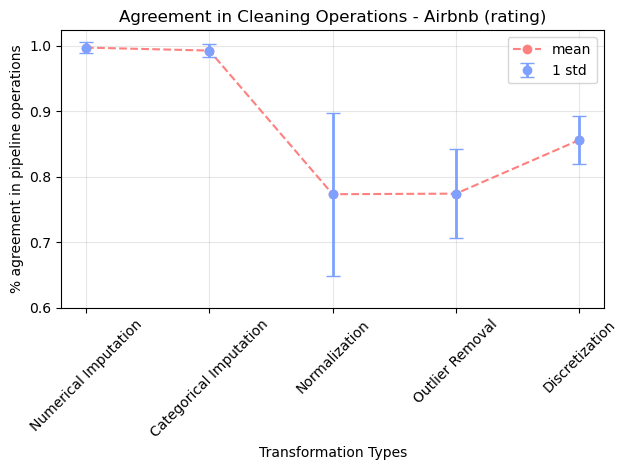

In [24]:
fig, ax = plt.subplots()

ax.plot(ops_agr_mean.keys(), list(ops_agr_mean.values()), color='#FE807F', label='mean', marker='o', linestyle='dashed')
plt.errorbar(ops_agr_mean.keys(), list(ops_agr_mean.values()), list(ops_agr_stddev.values()), fmt='o', capsize=5, elinewidth=2, color='#7EA1FF', label='1 std')

ax.set_xlabel("Transformation Types")
ax.set_ylabel("% agreement in pipeline operations")

ax.grid(alpha=0.3)

plt.yticks(np.arange(0.6, 1.01, 0.1))
plt.xticks(rotation=45)
plt.legend()

plt.title("Agreement in Cleaning Operations - Airbnb (rating)")
plt.tight_layout()
plt.savefig('./plots/airbnb_operation_comparison.png', dpi=200)


In [62]:
np.argmax(rating_pipeline_ops['pipeline.1.tf_prob_logits'], axis=1)

tensor([0, 0, 3, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])

In [29]:
-(synth_rating_pipeline_op * np.log2(rating_pipeline_op)).sum(axis=1).mean()

tensor(1.8055)

In [30]:
all_ces[-1]

[tensor(1.9815),
 tensor(0.9886),
 tensor(1.8246),
 tensor(2.6547),
 tensor(1.8055)]

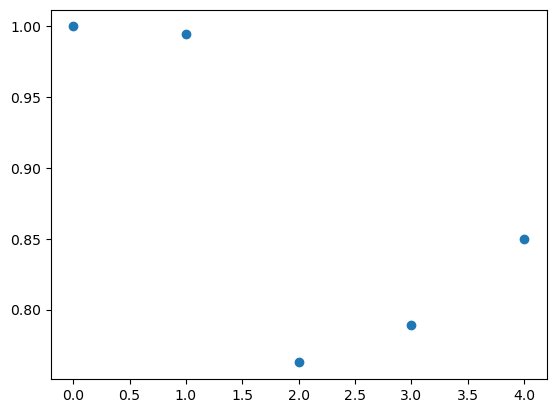

In [41]:
plt.scatter(range(0, 5), np.array(all_agrs).mean(axis=0))

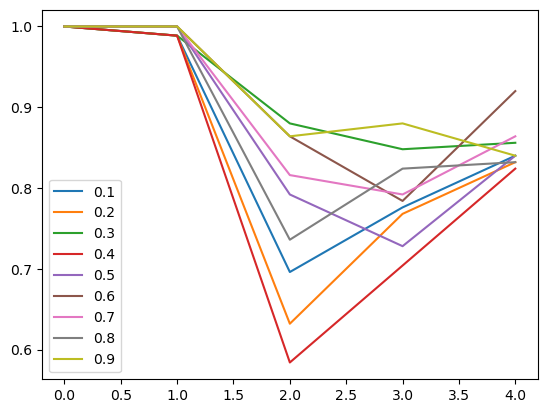

In [37]:
i = 0
for agr in all_agrs:
    plt.plot(agr, label=sims[i])
    i += 1
plt.legend()
plt.show()

In [13]:
corrs = [-0.763080467769026,
 -0.5592490401121984,
 -0.367428757351286,
 -0.2128637396841931,
 -0.02008864760288375,
 0.1713792572708421,
 0.37001616186636826,
 0.5572201070679217,
 0.7722228981929103]

In [17]:
mean_agr

[0.8601272727272727,
 0.8441272727272727,
 0.9145272727272727,
 0.8201272727272727,
 0.8719999999999999,
 0.9136,
 0.8943999999999999,
 0.8783999999999998,
 0.9168]

In [64]:
#for ce in all_ces:
#    plt.plot(sims, ce)
#plt.show()

In [126]:
#plt.errorbar(sims, mean_ce, [np.std(e) for e in all_ces])

In [132]:
sims, mean_ce

([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 [2.0640674,
  2.006621,
  2.05536,
  2.0044172,
  2.0128992,
  1.9931622,
  1.9532738,
  1.8628857,
  1.8858559])

Text(0.5, 1.0, 'Task Similarity vs. Pipeline Cross Entropy')

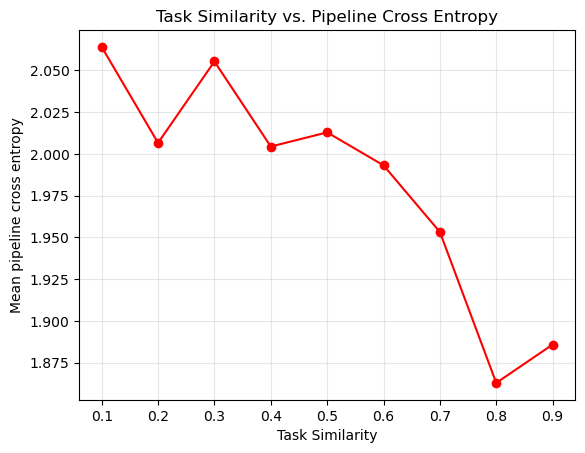

In [131]:
plt.plot(sims, mean_ce, color='red', marker='o')

plt.xlabel("Task Similarity")
plt.ylabel("Mean pipeline cross entropy")

plt.grid(alpha=0.3)
plt.title("Task Similarity vs. Pipeline Cross Entropy")